# Analysis of sequential DNA-MERFISH for SI14

by Pu Zheng

2022.05.30

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_7\20220616-hSTG0308_SI14_from_0601


In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

14124


## 0.1 Folders

In [44]:
save_folder = r'\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

204 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder


In [24]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])


save_filenames = save_filenames[:94]
save_fov_ids = save_fov_ids[:94]

# 1. Translate segmentation

In [11]:
# MERFISH segmentation info
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220601-hSTG\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(save_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    print(merfish_dapi_folder)
    os.makedirs(merfish_dapi_folder)

## 1.1 load rotation

In [12]:
# generate alignment
dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_7\20220616-hSTG0308_SI14_from_0601'
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear'

rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(dna_data_folder, 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_7\20220616-hSTG0308_SI14_from_0601\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99994601 -0.01039143]
 [ 0.01039143  0.99994601]],
 translation:[ -59.75780694 -591.04758076]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\translation


# 1.2 save DAPI image for RNA

In [45]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 25
- Number of field of views: 205


In [46]:
overwrite_dapi = False
for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _im = ia.visual_tools.DaxReader(os.path.join(ref_fd, rna_fovs[_fov_id])).loadAll()
        _dapi_im = _im[3::4]
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 1070.09it/s]


## 1.3 Prepare args

In [47]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [48]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    if os.path.isfile(_segmentation_savefile):
        continue
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

25
Wall time: 370 ms


## 1.4 test run and plot

In [18]:
import ImageAnalysis3.segmentation_tools.cell
reload(ia.segmentation_tools.cell)
sel_fov = 0
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [0.  3.4 7.5] in 1.562s.
-- drift 1: [-0.1  0.2  8.8] in 1.500s.
-- drift 2: [0.  0.3 4.9] in 1.547s.
-- drift 3: [0.  5.3 6.7] in 1.516s.
-- drift 4: [0.1 5.7 4.3] in 1.539s.
-- drift 5: [ 0.   2.2 12.4] in 1.507s.
-- drift 6: [0.  2.6 4.4] in 1.613s.
-- drift 7: [-0.1  3.4 10.6] in 1.513s.
-- return a sub-optimal drift
--- drift: [0.03 4.8  6.17] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


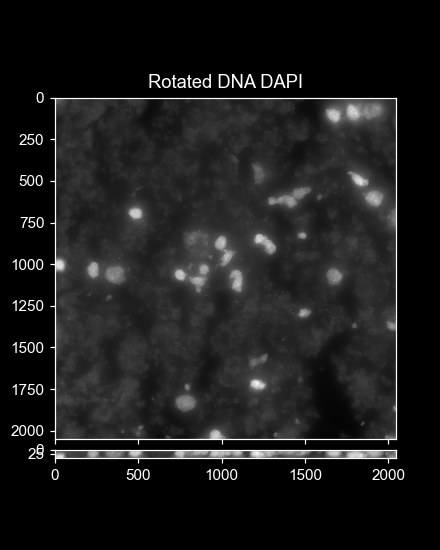

In [19]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_dna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated DNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

## 1.5 batch run translation

In [49]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(6) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 471.610s. 
Wall time: 7min 51s


### 1.5.2 non-parallel version

In [73]:
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [ ]:
%matplotlib inline
reload(ia.segmentation_tools.cell)
reload(correction_tools.alignment)
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
for _args in _seg_align_args:
    _outputs = _batch_align_segmentation(*_args)